In [68]:
import torch
from PIL import Image
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler

torch_device = "cuda"
torch_dtype = torch.float16

source_a = "CompVis/stable-diffusion-v1-4"
source_b = "openai/clip-vit-large-patch14"

vae = AutoencoderKL.from_pretrained(source_a, subfolder="vae", torch_dtype=torch_dtype).to(torch_device)
unet = UNet2DConditionModel.from_pretrained(source_a, subfolder="unet", torch_dtype=torch_dtype).to(torch_device)

scheduler = LMSDiscreteScheduler.from_pretrained(source_a, subfolder="scheduler", torch_dtype=torch_dtype)

tokenizer = CLIPTokenizer.from_pretrained(source_b)
text_encoder = CLIPTextModel.from_pretrained(source_b, torch_dtype=torch_dtype).to(torch_device)    

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.5.self_attn.out_proj.weight', 'vision_model.encoder.layers.5.mlp.fc2.weight', 'vision_model.encoder.layers.11.mlp.fc2.weight', 'vision_model.encoder.layers.9.layer_norm1.bias', 'vision_model.encoder.layers.22.self_attn.k_proj.bias', 'vision_model.encoder.layers.13.self_attn.k_proj.weight', 'vision_model.encoder.layers.20.mlp.fc1.bias', 'vision_model.encoder.layers.14.self_attn.v_proj.weight', 'vision_model.encoder.layers.21.self_attn.k_proj.bias', 'vision_model.encoder.layers.14.self_attn.k_proj.bias', 'vision_model.encoder.layers.7.self_attn.v_proj.weight', 'vision_model.encoder.layers.20.self_attn.v_proj.bias', 'vision_model.encoder.layers.7.self_attn.q_proj.weight', 'vision_model.encoder.layers.1.mlp.fc1.weight', 'vision_model.encoder.layers.18.self_attn.v_proj.weight', 'vision_model.encoder.layers.3.layer_norm2.weight', 'vision_model.enc

In [76]:
neg_prompt = ["NSFW, (worst quality:2), (low quality:2), (normal quality:2), lowres, normal quality, ((monochrome)), ((grayscale)), skin spots, acnes, skin blemishes, age spot, (ugly:1.331), (duplicate:1.331), (morbid:1.21), (extra legs:1.331), (fused fingers:1.5), (too many fingers:1.5), (unclear eyes:1.331), lowers, bad hands, missing fingers, extra digit, bad hands, missing fingers, (((extra arms and legs))),"]
prompt = ["Heat a large skillet or wok over medium heat, and pour in the sesame oil"]

height = 768                       # default height of Stable Diffusion
width = 768                         # default width of Stable Diffusion
num_inference_steps = 100            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(320)   # Seed generator to create the inital latent noise
batch_size = 1

text_input = tokenizer(
    prompt, 
    padding="max_length", 
    max_length=tokenizer.model_max_length, 
    truncation=True, 
    return_tensors="pt"
)

with torch.no_grad():
  text_embeddings = text_encoder(
    input_ids=text_input.input_ids.to(torch_device)
    )[0]


uncond_input = tokenizer(
    [""] * batch_size,
    padding="max_length", 
    max_length=text_input.input_ids.shape[-1], 
    return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   
  
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])


In [77]:
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device).half()

C:\Users\Eric\AppData\Local\Temp\ipykernel_28968\1645975362.py:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [78]:
scheduler.set_timesteps(num_inference_steps)

In [79]:
latents = latents * scheduler.init_noise_sigma

In [80]:
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


In [81]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

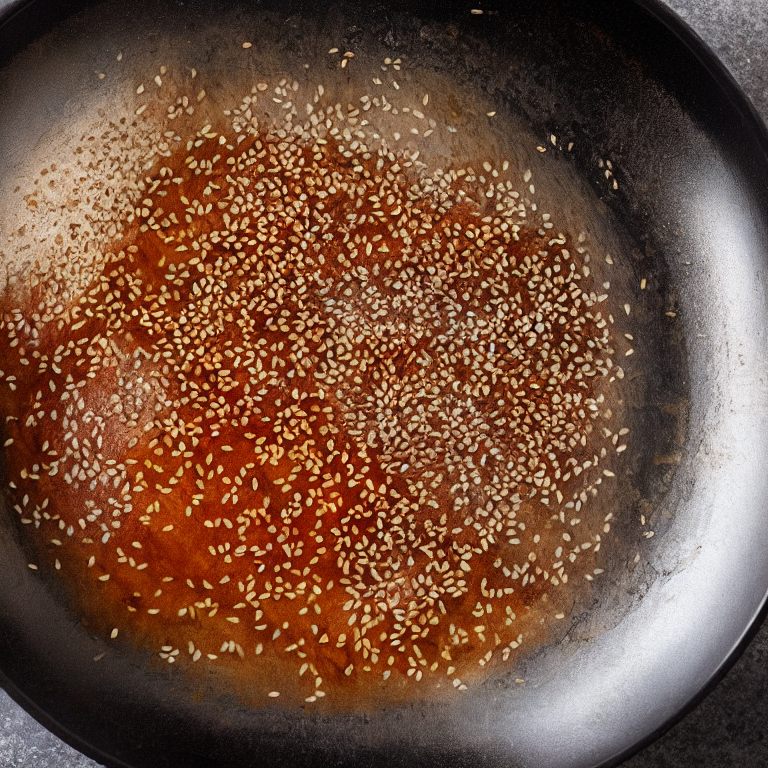

In [82]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]